In [1]:
import sys
print('Python:', sys.version)

# import libraries for machine learning
import torch
import torchvision
print('PyTorch:', torchvision.__version__)
print('Cuda is available' if torch.cuda.is_available() else 'Cuda is not avalaiable')

# import libraries for computer vision
import cv2 as cv
import numpy as np
print('Numpy:', np.__version__)
print('OpenCV:', cv.__version__)

# import libraries for visualization
import matplotlib
import matplotlib.pyplot as plt
print('matplotlib:', matplotlib.__version__)

# sys.path.append('../../')
print('sys.path:', sys.path)

Python: 3.6.9 (default, Aug  8 2019, 01:14:55) 
[GCC 7.4.0]
PyTorch: 0.4.0
Cuda is available
Numpy: 1.18.1
OpenCV: 4.2.0
matplotlib: 3.1.1
sys.path: ['/usr/local/lib/python36.zip', '/usr/local/lib/python3.6', '/usr/local/lib/python3.6/lib-dynload', '', '/home/sid1057/.local/lib/python3.6/site-packages', '/usr/local/lib/python3.6/site-packages', '/home/sid1057/.local/lib/python3.6/site-packages/IPython/extensions', '/home/sid1057/.ipython']


In [2]:
import torchvision.transforms as T

def torch_unsqueeze(input):
    return input.unsqueeze(0)

def CityScapesSemanticTarget(input):
    mask = np.asarray(input).astype(np.uint8)
    target = np.zeros((
            mask.shape[0],
            mask.shape[1]
    ), dtype=np.long)
    
    for city_class in torchvision.datasets.Cityscapes.classes:
        channel = city_class.id
        category = city_class.category_id
        if channel < 0:
            channel = len(torchvision.datasets.Cityscapes.classes)-1
        target[np.where(mask == channel)] = category
        
    return target

input_transform = T.Compose([
    #T.ToPILImage(),  # uncomment for usage with opencv images
    T.ToTensor(),
])

target_transform = T.Compose([
    #T.ToPILImage(),  # uncomment for usage with opencv images
    CityScapesSemanticTarget,
    T.ToTensor(),
])

def target_in_net_transform(x):
    return x.type(torch.LongTensor)[0]

In [3]:
from torchvision.models._utils import IntermediateLayerGetter
import torchvision.models.resnet as resnet

from torch.nn import functional as F

from collections import OrderedDict
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

squeeze = torchvision.models.squeezenet.squeezenet1_1(pretrained=True).eval()

class DeepSqueeze(torch.nn.Module):
    def __init__(self, num_classes):
        super(DeepSqueeze, self).__init__()
        backbone = squeeze.features

        classifier = DeepLabHead(512, num_classes)

        self.backbone = backbone
        self.classifier = classifier
        self.aux_classifier = None

    def forward(self, x):
        input_shape = x.shape[-2:]
        features = self.backbone(x)

        result = OrderedDict()
#         x = features["out"]
        x = features
        x = self.classifier(x)
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)

        return x

In [4]:
# Define the helper function
def decode_cityscapes_out(image, category=True):
    city_colors = np.asarray([i.color for i in torchvision.datasets.Cityscapes.classes])
    if category:
        city_colors = np.asarray([
            (128, 64, 128),
            (0, 0, 0),
            (248, 128, 248),
            (70, 70, 70),
            (153, 153, 153),
            (107, 142, 35),
            (70, 130, 180),
            (220, 20, 60),
            (0, 0, 142)])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
  
    for l in range(len(city_colors)):
        idx = image == l
        r[idx] = city_colors[l, 0]
        g[idx] = city_colors[l, 1]
        b[idx] = city_colors[l, 2]
    
    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [5]:
net = DeepSqueeze(35).eval().cuda().half()

In [6]:
net.load_state_dict(torch.load('/home/sid1057/Projects/Pension/CADAR/models/DLSQUEEZE_KITTI.pth', map_location='cuda:0'))

<All keys matched successfully>

In [7]:
net

DeepSqueeze(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2

In [8]:
img, mask = None, None

img = cv.imread('/home/sid1057/Projects/Pension/CADAR/data/carla_sequence_00/left/427284.7835.png')

input_transform = T.Compose([
    lambda x: cv.cvtColor(x, cv.COLOR_BGR2RGB),
    T.ToTensor(),
])

tensor = input_transform(cv.pyrDown(img)).cuda().unsqueeze(0).half()

In [9]:
print(tensor.shape)

torch.Size([1, 3, 360, 512])


In [10]:
output = net(tensor)

In [13]:
res = torch.argmax(output.squeeze(), dim=0).detach().cpu().numpy()
vis = decode_cityscapes_out(res, category=False)
vis = cv.pyrUp(vis)

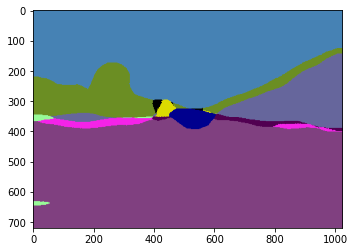

In [14]:
plt.imshow(vis)

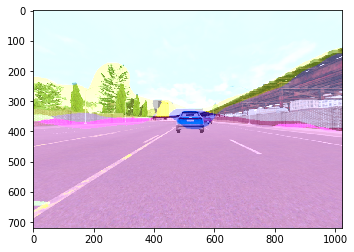

In [18]:
plt.imshow(cv.addWeighted(vis, 0.8, cv.cvtColor(img, cv.COLOR_BGR2RGB), 1, 0))

In [122]:
pts_front = np.array([
    [200, 580],
    [400, 450],
    [700, 450],
    [200, 580],
]).astype(np.float32)

pts_ipm_m = np.float32([
    [10, -2],
    [20, -2],
    [20, 2],
    [10, 2],
])
# pts_ipm_m[..., 0] -= max(pts_ipm_m[..., 0])
# pts_ipm_m[..., 0] *= -1

o_x, o_z = 0, 0
px_in_m = 20

pts_ipm = (pts_ipm_m)*px_in_m# + [40, 40]

pts_ipm = np.array([
    [300, 580],
    [500, 450],
    [800, 450],
    [300, 580],
]).astype(np.float32)

print(pts_front, pts_ipm)

H = cv.getPerspectiveTransform(pts_front, pts_ipm, cv.DECOMP_QR)

[[200. 580.]
 [400. 450.]
 [700. 450.]
 [200. 580.]] [[300. 580.]
 [500. 450.]
 [800. 450.]
 [300. 580.]]


In [123]:
H

array([[ 5.84104265e+00,  3.09150469e+00, -2.57321483e+03],
       [ 1.98690973e+00,  8.36171451e-01, -1.32099635e+02],
       [ 4.41535495e-03, -1.01640732e-03,  1.00000000e+00]])

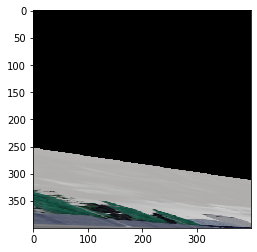

In [124]:
plt.imshow(cv.warpPerspective(img, H, (400, 400)))